<a href="https://colab.research.google.com/github/gulabpatel/ANN_CNN_TransferLearning/blob/master/14_Multitasking_NeauralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers, callbacks, losses, metrics
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt

# News Popularity Data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/gulabpatel/ANN_CNN_TransferLearning/master/dataset/OnlineNewsPopularity.csv")
data.columns = [col.strip() for col in data.columns]
data = data[data['shares']<100000]
data.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [3]:
data['shares'].describe(percentiles=[0.1,0.5,0.95])

count    39586.000000
mean      3100.751579
std       5991.066519
min          1.000000
10%        708.000000
50%       1400.000000
95%      10600.000000
max      98700.000000
Name: shares, dtype: float64

<Axes: ylabel='Frequency'>

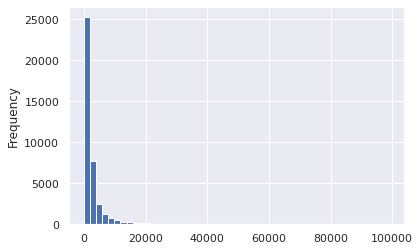

In [4]:
data['shares'].plot.hist(bins=50)

In [5]:
high_share_thresh = 10000
data["high_shares_y_n"] = data["shares"].apply(lambda shares: 1 if shares>high_share_thresh else 0)

In [6]:
data.dtypes.value_counts()

float64    59
int64       2
object      1
dtype: int64

In [7]:
data.drop("url", axis=1, inplace=True)
data.shape

(39586, 61)

In [8]:
data.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,high_shares_y_n
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,0
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,0
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,0
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,0
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,0


In [9]:
data.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,high_shares_y_n
count,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,...,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000
mean,354.523417,10.397994,546.517254,0.548278,0.996615,0.689271,10.878619,3.294271,4.541757,1.248446,...,0.756760,-0.259474,-0.521874,-0.107452,0.282267,0.071432,0.341809,0.155989,3100.751579,0.053731
std,214.209866,2.113984,470.721844,3.523278,5.235048,3.267194,11.327396,3.855810,8.308267,4.108235,...,0.247678,0.127641,0.290188,0.095269,0.324161,0.265346,0.188803,0.226225,5991.066519,0.225489
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.000000
25%,164.000000,9.000000,246.000000,0.470864,1.000000,0.625767,4.000000,1.000000,1.000000,0.000000,...,0.600000,-0.328282,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,945.000000,0.000000
50%,339.000000,10.000000,409.500000,0.539216,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000,0.000000
75%,542.000000,12.000000,716.000000,0.608584,1.000000,0.754627,14.000000,4.000000,4.000000,1.000000,...,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.148504,0.500000,0.250000,2800.000000,0.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,98700.000000,1.000000


In [10]:
unique_counts= pd.DataFrame()
counts = []
for col in data.columns:
    counts.append(data[col].nunique())

unique_counts['feature'] = data.columns
unique_counts['unique_count'] = counts
unique_counts = unique_counts.sort_values(by='unique_count')

# Preprocess Data

In [11]:
targets = ['shares', 'high_shares_y_n']
features = [col for col in data.columns if col not in targets]

In [12]:
X, y = data.drop(targets, axis=1), data[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_train = y_train.astype('float')
y_test = y_test.astype('float')

In [13]:
y_test['shares'].describe()

count     3959.000000
mean      3067.948472
std       5827.827336
min          8.000000
25%        933.500000
50%       1400.000000
75%       2700.000000
max      81700.000000
Name: shares, dtype: float64

In [14]:
y_train['shares'].describe()

count    35627.000000
mean      3104.396778
std       6009.001248
min          1.000000
25%        947.000000
50%       1400.000000
75%       2800.000000
max      98700.000000
Name: shares, dtype: float64

In [15]:
unique_counts[unique_counts['unique_count']==2]

,feature,unique_count
30,weekday_is_monday,2
37,is_weekend,2
36,weekday_is_sunday,2
35,weekday_is_saturday,2
34,weekday_is_friday,2
33,weekday_is_thursday,2
32,weekday_is_wednesday,2
31,weekday_is_tuesday,2
17,data_channel_is_world,2
16,data_channel_is_tech,2


In [16]:
scale_feats, do_not_scale = [], []

for feature in features:
    if X_train[feature].nunique()>2:
        scale_feats.append(feature)
    else:
        do_not_scale.append(feature)

In [17]:
scaler = StandardScaler()

X_train.loc[:, scale_feats] = scaler.fit_transform(X_train[scale_feats])
X_test.loc[:, scale_feats] = scaler.transform(X_test[scale_feats])

output_scaler = StandardScaler()
y_train.loc[:, 'shares'] = [val[0] for val in output_scaler.fit_transform(y_train['shares'].values.reshape(-1,1))]
y_test.loc[:, 'shares'] = [val[0] for val in output_scaler.transform(y_test['shares'].values.reshape(-1,1))]

# Define Model Architecture

In [18]:
num_features = len(features)

shared_dense_units_list = [64, 32]
regression_dense_units_list = [64, 16]
classification_dense_units_list = [32, 16]

In [19]:
def multi_task_model(num_features, shared_dense_units_list, regression_dense_units_list, classification_dense_units_list, batch_norm):
    
    # Input
    input_ = layers.Input(shape=(num_features,), name='Input')
    shared_x = layers.BatchNormalization(name=f'bn_inp')(input_)

    # Shared Layers
    for i, dense_units in enumerate(shared_dense_units_list):
        shared_x = layers.Dense(units = dense_units, name=f'shared_dense_{i+1}')(shared_x)
        shared_x = layers.ReLU(name=f'shared_relu_{i+1}')(shared_x)

        if batch_norm:
            shared_x = layers.BatchNormalization(name=f'shared_bn_{i+1}')(shared_x)

        shared_x = layers.Dropout(0.2, name=f'shared_dropout_{i+1}')(shared_x)


    # Regression Head
    if len(regression_dense_units_list)>0:
        regr_x = layers.Dense(units = regression_dense_units_list[0], name='regr_dense_1')(shared_x)
        regr_x = layers.ReLU(name=f'regr_relu_1')(regr_x)

    for i, dense_units in enumerate(regression_dense_units_list[1:]):
        regr_x = layers.Dense(units = dense_units, name=f'regr_dense_{i+2}')(regr_x)
        regr_x = layers.ReLU(name=f'regr_relu_{i+2}')(regr_x)

        if batch_norm:
            regr_x = layers.BatchNormalization(name=f'regr_bn_{i+1}')(regr_x)

        regr_x = layers.Dropout(0.2, name=f'regr_dropout_{i+1}')(regr_x)

    if len(regression_dense_units_list)>0:
        regr_output = layers.Dense(1, name='regr_out')(regr_x)
    else:
        regr_output = layers.Dense(1, name='regr_out')(shared_x)


    # Classification Head
    if len(classification_dense_units_list)>0:
        clsf_x = layers.Dense(units = classification_dense_units_list[0], name='clsf_dense_1')(shared_x)
        clsf_x = layers.ReLU(name=f'clsf_relu_1')(clsf_x)

    for i, dense_units in enumerate(classification_dense_units_list[1:]):
        clsf_x = layers.Dense(units = dense_units, name=f'clsf_dense_{i+2}')(clsf_x)
        clsf_x = layers.ReLU(name=f'clsf_relu_{i+2}')(clsf_x)

        if batch_norm:
            clsf_x = layers.BatchNormalization(name=f'clsf_bn_{i+1}')(clsf_x)

        clsf_x = layers.Dropout(0.2, name=f'clsf_dropout_{i+1}')(clsf_x)

    if len(classification_dense_units_list)>0:
        clsf_output = layers.Dense(1, name='p_clsf', activation='sigmoid')(clsf_x)
    else:
        clsf_output = layers.Dense(1, name='p_clsf', activation='sigmoid')(shared_x)


    model = Model(input_, [regr_output, clsf_output], name='model')
    
    return model



def plot_metrics(model_history, metrics):
    
    n_cols = 2
    n_rows = int(np.ceil(len(metrics)/n_cols))
    
    fig, ax = plt.subplots(n_rows, n_cols, sharex=False, sharey=False, figsize=(12,5*n_rows))
    ax = np.array(ax)
    ax = ax.flatten()

    for i, metric in enumerate(metrics):
        ax[i].plot(model_history.history[metric], label='Training')
        ax[i].plot(model_history.history['val_'+metric], label='Validation')
        ax[i].set_title(metric)
        ax[i].legend()
        ax[i].set(xlabel='Epoch')

    fig.tight_layout()
    plt.show()

    return fig

In [20]:
model = multi_task_model(num_features=num_features,
                        shared_dense_units_list=shared_dense_units_list,
                        regression_dense_units_list=regression_dense_units_list,
                        classification_dense_units_list=classification_dense_units_list,
                        batch_norm=False)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 59)]         0           []                               
                                                                                                  
 bn_inp (BatchNormalization)    (None, 59)           236         ['Input[0][0]']                  
                                                                                                  
 shared_dense_1 (Dense)         (None, 64)           3840        ['bn_inp[0][0]']                 
                                                                                                  
 shared_relu_1 (ReLU)           (None, 64)           0           ['shared_dense_1[0][0]']         
                                                                                              

# Train Model

In [22]:
import tensorflow.keras.backend as K
def scaled_mse(y_true, y_pred):
    #difference between true label and predicted label
    error = y_true-y_pred    
    #square of the error
    sqr_error = K.square(error)
    #mean of the square of the error
    mean_sqr_error = K.mean(sqr_error)

    return mean_sqr_error/3.

    

def output_form(data):
    regr = data['shares']
    regr = np.array(regr)
    clsf = data['high_shares_y_n']
    clsf = np.array(clsf)
    return (regr, clsf)

train_y = output_form(y_train)
test_y = output_form(y_test)

In [23]:
EPOCHS = 500

In [24]:
learning_rate = 1e-04

# Compile Model
opt = optimizers.Adam(learning_rate)
model.compile(optimizer=opt,
                loss={'p_clsf' : tf.keras.losses.BinaryCrossentropy(),
                     'regr_out' : tf.keras.losses.MeanSquaredError()},
                metrics={'p_clsf':[tf.keras.metrics.AUC(name='auc')],
                        'regr_out': [tf.keras.metrics.RootMeanSquaredError(name='rmse'), tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]})

In [25]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, min_delta=0.001)

# Fit
history = model.fit(x=X_train.values,
                    y=train_y,
                    validation_data = (X_test.values, test_y),
                    epochs=EPOCHS,
                    callbacks=[early_stop],
                    batch_size=64)

Epoch 1/500
557/557 [==============================] - 5s 5ms/step - loss: 1.4609 - regr_out_loss: 1.0286 - p_clsf_loss: 0.4323 - regr_out_rmse: 1.0142 - regr_out_mape: 270.2967 - p_clsf_auc: 0.4909 - val_loss: 1.1636 - val_regr_out_loss: 0.9293 - val_p_clsf_loss: 0.2343 - val_regr_out_rmse: 0.9640 - val_regr_out_mape: 156.8165 - val_p_clsf_auc: 0.4893
Epoch 2/500
557/557 [==============================] - 4s 7ms/step - loss: 1.2491 - regr_out_loss: 0.9966 - p_clsf_loss: 0.2525 - regr_out_rmse: 0.9983 - regr_out_mape: 187.4075 - p_clsf_auc: 0.4966 - val_loss: 1.1321 - val_regr_out_loss: 0.9236 - val_p_clsf_loss: 0.2084 - val_regr_out_rmse: 0.9610 - val_regr_out_mape: 161.6756 - val_p_clsf_auc: 0.5609
Epoch 3/500
557/557 [==============================] - 6s 11ms/step - loss: 1.2227 - regr_out_loss: 0.9892 - p_clsf_loss: 0.2334 - regr_out_rmse: 0.9946 - regr_out_mape: 198.5152 - p_clsf_auc: 0.5533 - val_loss: 1.1170 - val_regr_out_loss: 0.9194 - val_p_clsf_loss: 0.1976 - val_regr_out_rm

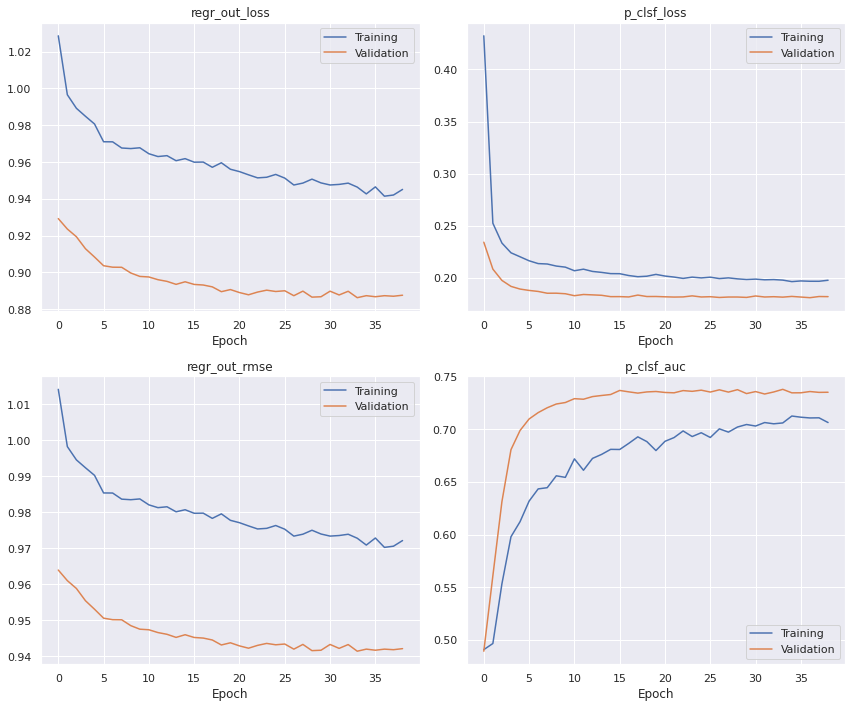

In [26]:
fig = plot_metrics(history, metrics=['regr_out_loss', 'p_clsf_loss', 'regr_out_rmse', 'p_clsf_auc'])

plt.show()

In [27]:
model.save('models/mtl_model')

In [28]:
model.predict(X_test.loc[0:1,:])

1/1 [==============================] - 0s 233ms/step


[array([[0.32743996],
        [0.47319877]], dtype=float32), array([[0.14814033],
        [0.20063563]], dtype=float32)]

# SHAP Explanations

In [ ]:
!pip install shap

In [32]:
import shap
from shap import DeepExplainer

In [33]:
shap.initjs()

## Regression Model

In [34]:
regr_model = Model(model.input, model.output[0])

In [35]:
sample_data = X_train.sample(n=2000, random_state=2) # background dataset

explain_dataset = X_train.sample(n=5000, random_state=3) # data on which we want explanations

In [36]:
deep_explainer = DeepExplainer(regr_model, 
                               [sample_data.values])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [37]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
# shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

In [38]:
shap_vals = deep_explainer.shap_values(explain_dataset.values)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Summary Plots

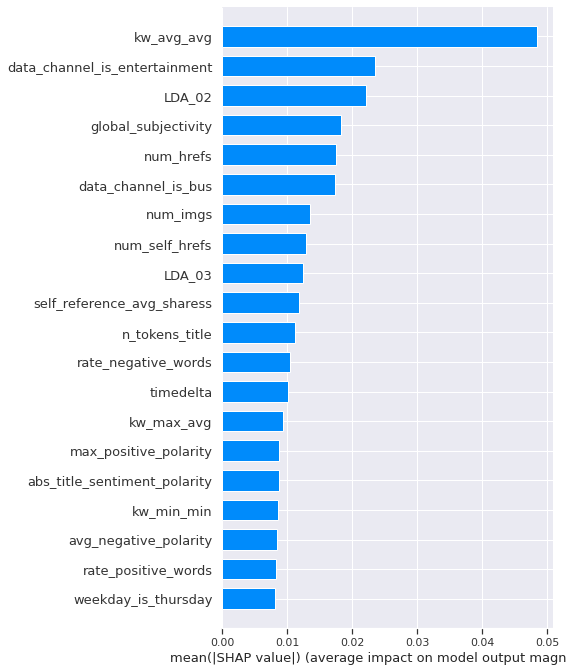

In [39]:
shap.summary_plot(shap_values=shap_vals[0],
                  features=explain_dataset,
                  feature_names=X_train.columns,
                  max_display=20,
                  plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


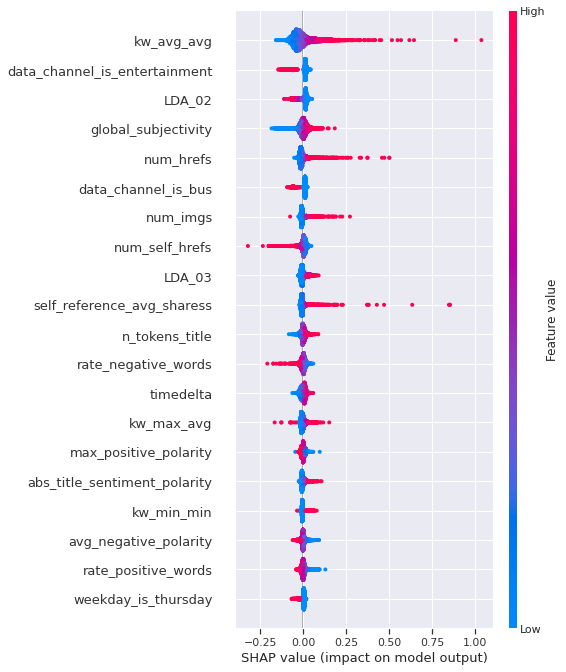

In [40]:
shap.summary_plot(shap_values=shap_vals[0],
                  features=explain_dataset,
                  feature_names=X_train.columns,
                  max_display=20)

## Sample Explanations

In [41]:
def sample_level_details(explain_index, explain_dataset, bg_data, shap_vals):
    sample_detail = pd.concat([explain_dataset.iloc[explain_index,:], bg_data.mean()], axis=1)

    sample_detail.columns = ['sample_value', 'mean_bg_value']
    sample_detail['contribution'] = shap_vals[0][explain_index]

    sample_detail = sample_detail.sort_values('contribution', ascending=False)

    return sample_detail

In [42]:
index=20
shap.force_plot(base_value=deep_explainer.expected_value[0].numpy(),
                shap_values=shap_vals[0][index],
                features=explain_dataset.iloc[index,:],
                feature_names=X_train.columns)

In [43]:
sample_detail = sample_level_details(explain_index=20,
                                    explain_dataset=explain_dataset,
                                    bg_data=sample_data,
                                    shap_vals=shap_vals)
sample_detail

,sample_value,mean_bg_value,contribution
n_tokens_title,1.230416,-0.007118,0.020268
LDA_02,-0.649146,-0.023616,0.019786
rate_negative_words,-1.843560,-0.045994,0.019053
data_channel_is_entertainment,0.000000,0.180500,0.015280
data_channel_is_bus,0.000000,0.155000,0.012500
global_rate_positive_words,2.674961,0.038616,0.012488
data_channel_is_socmed,1.000000,0.062000,0.007204
weekday_is_wednesday,0.000000,0.190500,0.005770
max_positive_polarity,-0.228358,0.036095,0.005709
min_positive_polarity,-0.869619,-0.001005,0.005685


## Classification Model

In [44]:
clsf_model = Model(model.input, model.output[1])

In [45]:
deep_explainer_clsf = DeepExplainer(clsf_model, 
                                    [sample_data.values])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [46]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
# shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

In [47]:
shap_vals_clsf = deep_explainer_clsf.shap_values(explain_dataset.values)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Summary Plots

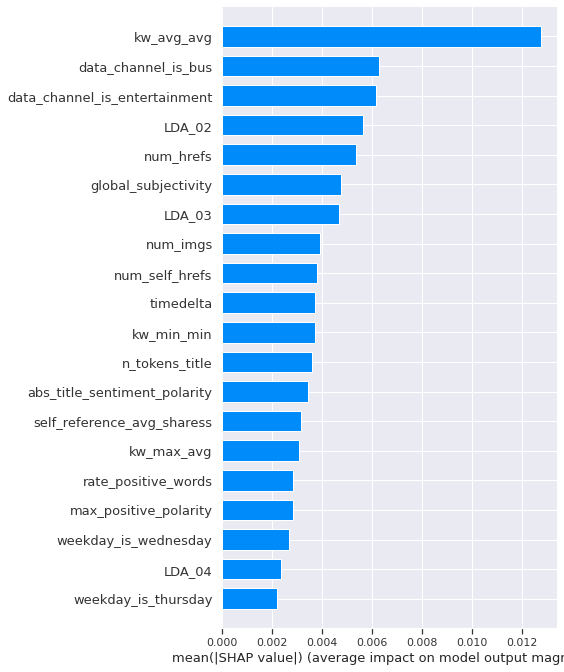

In [48]:
shap.summary_plot(shap_values=shap_vals_clsf[0],
                  features=explain_dataset,
                  feature_names=X_train.columns,
                  max_display=20,
                  plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


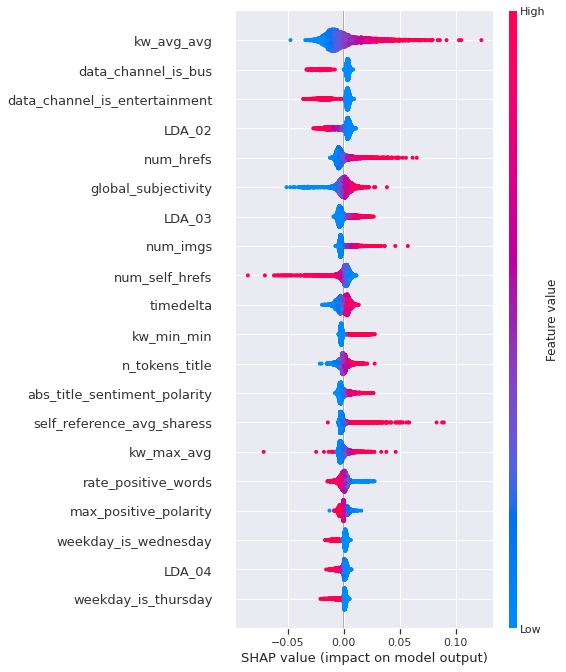

In [49]:
shap.summary_plot(shap_values=shap_vals_clsf[0],
                  features=explain_dataset,
                  feature_names=X_train.columns,
                  max_display=20)

## Sample Explanations

In [52]:
shap.initjs()

In [53]:
index=20
shap.force_plot(base_value=deep_explainer_clsf.expected_value[0].numpy(),
                shap_values=shap_vals_clsf[0][index],
                features=explain_dataset.iloc[index,:],
                feature_names=X_train.columns)

In [51]:
sample_detail = sample_level_details(explain_index=20,
                                    explain_dataset=explain_dataset,
                                    bg_data=sample_data,
                                    shap_vals=shap_vals_clsf)
sample_detail

,sample_value,mean_bg_value,contribution
n_tokens_title,1.230416,-0.007118,0.008541
LDA_02,-0.649146,-0.023616,0.005835
data_channel_is_bus,0.000000,0.155000,0.005418
data_channel_is_entertainment,0.000000,0.180500,0.005382
global_rate_positive_words,2.674961,0.038616,0.003871
rate_negative_words,-1.843560,-0.045994,0.003153
abs_title_sentiment_polarity,0.492178,0.045896,0.002856
data_channel_is_socmed,1.000000,0.062000,0.002569
max_negative_polarity,1.129827,0.054778,0.002531
kw_avg_avg,0.104045,-0.005399,0.002428
